# TDT 4173 - Machine Learning Project - Long Notebook

### Kaggle team name: 121 - Team Sondre Skjerven


#### Participants
Name: Hedda Flemmen Holum:) \
Student ID: 544531


Name: Sondre Skjerven \
Student ID: 564376


Name: Tallak Ravn \
Student ID: 544531

| Criteria                              | How we covered it                                                                                                   | Lookup keyword |
|---------------------------------------|-----------------------------------------------------------------------------------------------------------------|------------------------|
| EDA: Domain Knowledge                 | See below.                                                                                                      | [Domain]               |
| EDA: Check intuitive data             | Explain time series and how data must be understood.                                                         | [Intuitive]            |
| EDA: Understand data generation       | See below.                                                                                                      | [Generation]           |
| EDA: Explore individual features      | We made feature distribution plots                                                                              | [Individual]           |
| EDA: Explore feature pairs & groups   | Made plots for correlation between pv_measurement and the rest of the features. Also plotted correlation matrix with all features. | [Pairs & Groups]       |
| EDA: Clean up features                | Removed missing values, consecutive non-zeros, consecutive zeros over length 24                                 | [Cleaning]             |
| Multiple types of predictors          | We have tried Pycaret, pure catboost and Autogluon as predictors. Both Pycaret and Autogluon are AutoML models which try several different base models. | [Multiple predictors]  |
| Feature engineering                   | Made cosine and sine transformations of the hour, week and month columns.                                      | [Feature engineering]  |
| Model interpretation                  | Plotted feature importance for the Pycaret model to see what features have the most explainability. Plotted predictions for all models.            | [Model interpretation] |


# Reproduction of results

The notebooks assume that the data folder is in the same folder as the notebook. 

Folder structure:

short_notebook1.ipynb \
short_notebook2.ipynb\
long_notebook_ML.ipynb\
data (folder)


In [ ]:
# Uncomment and run the following to install the required packages
# !pip install 'nbformat>=4.2.0' (might need to restart kernel after)
# !pip install wheel
# !pip install -r requirements.txt

# Domain Knowledge / Data Generation / Data Intuition

### AIS Vessel Trajectory Prediction [Domain] Knowledge

Automatic Identification System (AIS) is an internationally adopted system for tracking and identifying vessels to improve maritime safety. AIS operates by using transponders that broadcast a vessel's location, speed, heading, and identity, which can then be received by other vessels and coastal stations within VHF range. The system’s self-organizing time division multiple access (SOTDMA) allows efficient use of radio channels, even in crowded maritime environments, by assigning specific time slots for each transmission. This autonomous setup ensures that vessels in proximity receive accurate data without signal interference or delay (United States Coast Guard, n.d.-b).

AIS data includes essential navigation information such as Course Over Ground (COG), Speed Over Ground (SOG), and navigational status, which together offer a snapshot of each vessel's behavior and movement at any given time. However, various factors affect AIS data reliability. For example, environmental elements like poor visibility, high traffic, or obstruction from land masses can distort or limit signal accuracy, impacting both real-time monitoring and historical data analysis for machine learning purposes (International Maritime Organization, n.d.).

The system is required on most large vessels under SOLAS regulations, but not all smaller vessels are mandated to carry AIS transponders. As a result, AIS data may have coverage gaps, especially in regions where smaller vessels are prevalent. The continuous broadcast requirement ensures that equipped vessels are always visible unless they turn off the transponder for security or operational reasons. This makes AIS a critical tool for monitoring vessel movements, but limitations in its coverage and reliability mean that additional data sources may be necessary to complete the maritime traffic picture (United States Coast Guard, n.d.-a).

AIS has evolved to address both collision prevention and maritime traffic monitoring. It enables vessels to identify others by name, position, and vector, aiding in collision avoidance and allowing early maneuvers to prevent accidents. Additionally, AIS data is archived, providing valuable historical data for studying maritime patterns and informing predictive models, making it a vital source for machine learning applications aimed at trajectory prediction and anomaly detection (Kystverket, n.d.).

Despite its advantages, AIS data is susceptible to human errors and discrepancies. Studies have shown that errors in inputting vessel information, such as incorrect speed or heading, can lead to misleading transmissions, posing a risk if AIS data is heavily relied upon without verification. For machine learning models, understanding and accounting for these potential inaccuracies is crucial for enhancing prediction reliability (Harati-Mokhtari et al., 2007).

__References:__ 

Harati-Mokhtari, A., Wall, A., Brooks, P., & Wang, J. (2007). Automatic Identification System (AIS): Data reliability and human error implications. _Journal of Navigation, 60(3)_, 373–389. https://doi.org/10.1017/S0373463307004298

International Maritime Organization. (n.d.). AIS transponders. Retrieved from https://www.imo.org/en/OurWork/safety/navigation/ais.aspx (08.11.24)

Kystverket. (n.d.). AIS Norge. Retrieved from https://www.kystverket.no/navigasjonstjenester/ais/ais-artikkelside/ (08.11.24)

United States Coast Guard. (n.d.-a). Automatic identification system overview. Retrieved from https://www.navcen.uscg.gov/automatic-identification-system-overview (08.11.24)

United States Coast Guard. (n.d.-b). How AIS works. Retrieved from https://www.navcen.uscg.gov/how-ais-works (08.11.24)

### Data generation and structure

The main dataset in the project is the AIS data ("Automatic Identification system"). An international collection of vessels is equipped with a system allowing for real time tracking of a number of variables. The dataset provides real time info about the individual vessels, including their speed and course. In order to ensure a well-functioning and safe international maritime traffic, this form of data is critical. Examples of the specific use cases are navigation and collision avoidance. As emphasized in the documentation and the project handout, the data might include inaccuracies due to signal errors or humans. This will be addressed later.

It's also worth giving some introductory information about the data structure. A single row/record in the AIS dataset represents a single observation of a specific vessel at a specific time, including variables such as the observed speed and course. Filtering on a single vessel (by a uniquely identifying 'vesselId') and sorted by time yields a dataset of the overall observed trajectory for that specific vessel (as illustated by the handout 'Visualize_last_vessel_pos.ipynb'). A row is uniquely identified by its timestamp ('time') combined with the vessel ('vesselId').

The handout also includes a vessel dataset, with information regarding the shipping line, volume, type and dimensions among others. This dataset can be linked to AIS as dimensional data joined on the vesselIds. Furthermore, there is also a port dataset, with information regarding the ports with corresponding position, name and countries. This set can also be combined with the AIS data using the 'portId' column.


### Data intuition

It's worth dedicating some attention to understanding the data and creating a fundamental intuition regarding the relation between the training and the test set. To do this, we will use snippets from the set. The train set is represented through the 50 000 first rows in the set:

In [2]:
import pandas as pd

train_set = pd.read_csv('first_50000_rows.csv', sep='|')
train_set.head(5)

,time,cog,sog,rot,heading,navstat,etaRaw,latitude,longitude,vesselId,portId
0,2024-01-01 00:00:25,284.0,0.7,0,88,0,01-09 23:00,-34.74370,-57.85130,61e9f3a8b937134a3c4bfdf7,61d371c43aeaecc07011a37f
1,2024-01-01 00:00:36,109.6,0.0,-6,347,1,12-29 20:00,8.89440,-79.47939,61e9f3d4b937134a3c4bff1f,634c4de270937fc01c3a7689
2,2024-01-01 00:01:45,111.0,11.0,0,112,0,01-02 09:00,39.19065,-76.47567,61e9f436b937134a3c4c0131,61d3847bb7b7526e1adf3d19
3,2024-01-01 00:03:11,96.4,0.0,0,142,1,12-31 20:00,-34.41189,151.02067,61e9f3b4b937134a3c4bfe77,61d36f770a1807568ff9a126
4,2024-01-01 00:03:51,214.0,19.7,0,215,0,01-25 12:00,35.88379,-5.91636,61e9f41bb937134a3c4c0087,634c4de270937fc01c3a74f3


In [3]:
test_set = pd.read_csv('ais_test.csv')
test_set.head(5)

,ID,vesselId,time,scaling_factor
0,0,61e9f3aeb937134a3c4bfe3d,2024-05-08 00:03:16,0.3
1,1,61e9f473b937134a3c4c02df,2024-05-08 00:06:17,0.3
2,2,61e9f469b937134a3c4c029b,2024-05-08 00:10:02,0.3
3,3,61e9f45bb937134a3c4c0221,2024-05-08 00:10:34,0.3
4,4,61e9f38eb937134a3c4bfd8d,2024-05-08 00:12:27,0.3


The main thing to note here is that the training set includes a number of features that are not present in the test set. As an immediate conclusion, we can say that we will have to find a work-around for this. The core idea behind machine learning regression is to use a target variable's relationship with other variables to make predictions about the target variable when we don't have access to the target variable itself. A model trained on data with columns A, B, C, D and E might be able to say something about the probable values of E when only provided data with columns A, B, C and D if there are indeed underlying relationships between E and any of the remaining columns.

Quickly looking at the datasets, we see that the only variables in common between the train and the test set are the "vesselId" and the "time" columns. Without any modification, and using our previous illustration, a simple regression using these datasets directly would therefore require that the model should predict positions ***purely*** based on a vesselId and a time, without any other information. This surely appears to be a hard task. Adding to that the fact that all the test records appear at a later stage in time than all the train records, we can conclude that we really have to structure things in a different manner.

We do, however, indeed have more information relevant to the test sets. Even though we can't create columns such as 'rot', 'cog' and 'sog' from thin air, we can leverage the fact that we have access to historical data. A core idea to get comfortable with as we move along is that the data records should be viewed in relation ***to eachother*** as time series - not just by themselves.

Without diving into the technicals quite yet, we will reveal that looking at the ***earlier positions*** of the vessel will be a key way to address this data complexity issue. We can for example, at all points in time, know with certainty what was the ***last observed*** position of a vessel.

# Exploring the data / EDA

### Initial look at the columns

In order to wrap our heads around the data we are dealing with, we explore our dataset a bit. For now, we will be dealing exclusively with the training set, as the test set are only timestamps and vesselIds.

In [ ]:
train_set.info()

# TODO: argumenter for at PortId kan fjernes pga alle de som mangler 
# TODO: etaRaw kan fjernes også?

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   time       50000 non-null  object 
 1   cog        50000 non-null  float64
 2   sog        50000 non-null  float64
 3   rot        50000 non-null  int64  
 4   heading    50000 non-null  int64  
 5   navstat    50000 non-null  int64  
 6   etaRaw     50000 non-null  object 
 7   latitude   50000 non-null  float64
 8   longitude  50000 non-null  float64
 9   vesselId   50000 non-null  object 
 10  portId     49797 non-null  object 
dtypes: float64(4), int64(3), object(4)
memory usage: 4.2+ MB


As we see, the set has very few missing data points. This is lucky for us, as missing values necessarily require handling, and we as data analysts are responsible for doing exactly that in an appropriate way. The data might however, still be bad. We will dive deeper into that aspect later. As of now, we can conclude that no columns are excluded purely because of too many missing values.

Moving on, we would like to see the different values and ranges appearing in the columns:

In [12]:
for column in train_set.columns:
    print(f"{column} - Unique values count: {train_set[column].nunique()}")

time - Unique values count: 31859
cog - Unique values count: 3597
sog - Unique values count: 243
rot - Unique values count: 73
heading - Unique values count: 361
navstat - Unique values count: 7
etaRaw - Unique values count: 621
latitude - Unique values count: 25780
longitude - Unique values count: 26269
vesselId - Unique values count: 435
portId - Unique values count: 380


As we see, most of the columns have a wide range of different values. This makes perfect sense, as well documented and explained in the 'Dataset definitions and explanations' file in the handout. In fact, most columns are actually continous as well. This means that the set of possible values for the column is infinitely large (at least in theory), even though there might be restrictions on the minimum and maximum values. An example would be longitudes and latitudes, which are recorded as float values (decimals). There are infinitely many decimal numbers between any two arbitrary decimal numbers, so there should be an unrestricted amount of lonitudes and latitudes in the range of possible values. To be fair, the devices recording the longitudes and latitudes (and other variables) are probably object to physical constraints, and only able to track position to a certain decimal. So, in practice there might in fact be a finite number of possible values for these. Nevertheless, we will move on viewing the sets of possibilities for these as infinitely big.

The only columns that are truly categorical are navstat, vesselId and portId. 

- ***Navstat***: Indicating one of 16 different 'navigational statuses' (documentation). These are discrete, mutually exclusive states implemented through integer values from 0 to 15. There are only 16 possible values (and possibly fewer in practice).

- ***vesselId***: Indicating which of the 711 possible vessels is observed in the record. These are also discrete, mutually exclusive IDs referring to vessels present in the 'vessels.csv' file.

- ***portId***: Similar to the vesselId: Indicating which of the possible 1329 is set by the captain either as destination or origin port. Can only be an existing port.

### Distribution of values
må gå over "konklusjonene" for de gir ikke helt mening nå. må også sjekke hvilke type båter som faktisk blir tracket med ais mtp realistik speed. må også sjekke opp i hva 112,2 og 112,3 betyr?

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv('ais_train.csv', delimiter='|')

#### Speed Over Ground (SOG) !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

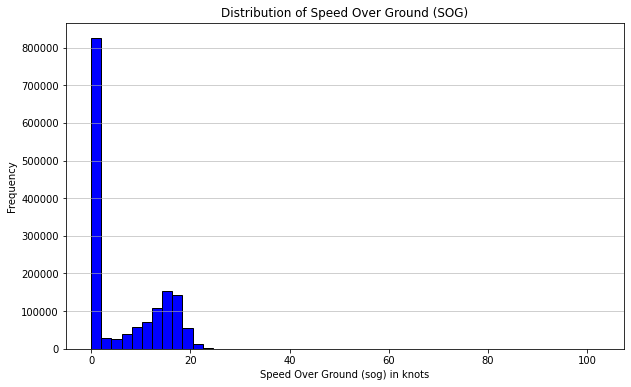

In [8]:
# Plotting the histogram for Speed Over Ground (SOG)
plt.figure(figsize=(10, 6))
plt.hist(data['sog'], bins=50, color='blue', edgecolor='black')
plt.title('Distribution of Speed Over Ground (SOG)')
plt.xlabel('Speed Over Ground (sog) in knots')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

The initial histogram of Speed Over Ground (SOG) shows that more than half of the data entries are from times when vessels are stationary or in port, indicated by a speed of zero. For entries where vessels are in motion, speeds cluster between 0 and 25 knots, which aligns with typical maritime transit speeds. The presence of high values (e.g., 102.3 knots) is likely due to data errors, as the fastest recorded cargo ship reaches only 34.97 knots. Therefore, speeds above 35 knots are considered implausible and have been removed from the dataset. The significant concentration of zero-speed entries aligns with the expectation that a substantial portion of vessels are stationary or at low speeds, possibly anchored or moored.

#### Rate of Turn (ROT)

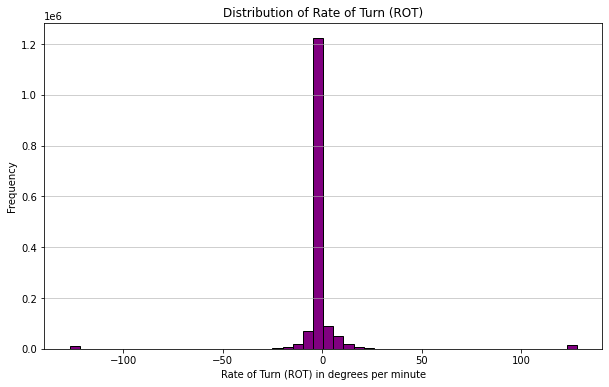

In [10]:
# Plotting the histogram for Rate of Turn (ROT)
plt.figure(figsize=(10, 6))
plt.hist(data['rot'], bins=50, color='purple', edgecolor='black')
plt.title('Distribution of Rate of Turn (ROT)')
plt.xlabel('Rate of Turn (ROT) in degrees per minute')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()


In [12]:
import pandas as pd

# Define the categories for ROT
categories = {
    "Turning right (0 to +126)": data[(data['rot'] > 0) & (data['rot'] <= 126)].shape[0],
    "Turning left (0 to -126)": data[(data['rot'] < 0) & (data['rot'] >= -126)].shape[0],
    "Turning right (> +127)": data[data['rot'] == 127].shape[0],
    "Turning left (< -127)": data[data['rot'] == -127].shape[0],
    "No turn information (-128)": data[data['rot'] == -128].shape[0],
    "Stationary (ROT = 0)": data[data['rot'] == 0].shape[0]
}

# Display the counts for each category
for category, count in categories.items():
    print(f"{category}: {count} entries")

Turning right (0 to +126): 169035 entries
Turning left (0 to -126): 168051 entries
Turning right (> +127): 11339 entries
Turning left (< -127): 11042 entries
No turn information (-128): 0 entries
Stationary (ROT = 0): 1157035 entries


The Rate of Turn (ROT) histogram reveals key patterns in vessel maneuvering behavior. The majority of entries, approximately 1.2 million, have an ROT of zero, indicating that most vessels are either stationary or maintaining a steady, straight course. Of these, over 800,000 entries likely capture vessels at port with zero speed. For moving vessels, there are 169,035 entries with positive ROT values (0 to +126) representing right turns and 168,051 entries with negative values (0 to -126) representing left turns. These counts suggest balanced maneuvering behavior, with vessels making gradual to sharp turns in both directions up to a maximum of 708 degrees per minute. Additionally, there are 11,339 entries at +127 and 11,042 entries at -127, indicating right and left turns, respectively, with unspecified high turn rates. These entries likely represent sharp or emergency maneuvers, where precise rate information isn’t available. Notably, there are no entries with an ROT of -128, a default AIS value for missing turn information, indicating that ROT data in this dataset is largely complete.

#### NavStat (Navigational Status)

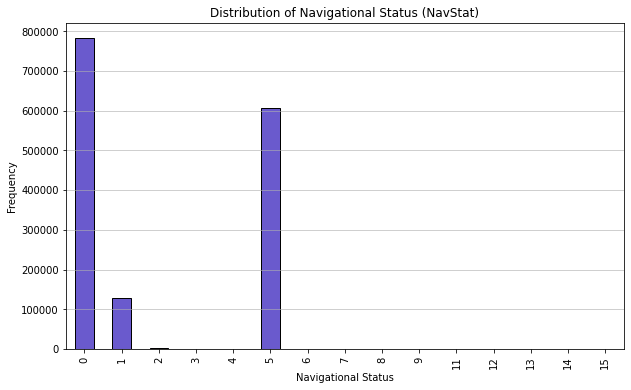

In [25]:
# Plotting the bar chart for Navigational Status (NavStat)
plt.figure(figsize=(10, 6))
data['navstat'].value_counts().sort_index().plot(kind='bar', color='slateblue', edgecolor='black')
plt.title('Distribution of Navigational Status (NavStat)')
plt.xlabel('Navigational Status')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()


In [26]:
# Counting occurrences of each NavStat code
navstat_counts = data['navstat'].value_counts().sort_index()

# Display the counts in a readable format
print(navstat_counts)


navstat
0     782099
1     129515
2       2081
3        161
4        232
5     605831
6        521
7          1
8        948
9          1
11         2
12         1
13         1
14         1
15       670
Name: count, dtype: int64


The Navigational Status (NavStat) distribution highlights key patterns in vessel operations within the dataset. The majority of entries fall under Code 0 ("Under way using engine") with 782,099 occurrences, indicating that most vessels are actively moving. Code 5 ("Moored") is the second most common status, with 605,831 entries, suggesting a large number of vessels are stationary at port. Additionally, Code 1 ("At anchor") appears in 129,515 entries, reflecting frequent stationary periods near anchorages. Less common statuses, such as Code 2 ("Not under command") with 2,081 entries and Code 3 ("Restricted maneuverability") with 161 entries, represent exceptional conditions. Rare or reserved codes (e.g., Codes 9, 11–14) have minimal occurrences, likely due to incidental or placeholder data. The Not defined status (Code 15) appears 670 times, possibly indicating default or missing information. Overall, this distribution underscores a dataset that captures a balance between vessels in transit and those at port or anchor, with a minor portion of entries representing unusual operational states.

#### Course Over Ground (COG)

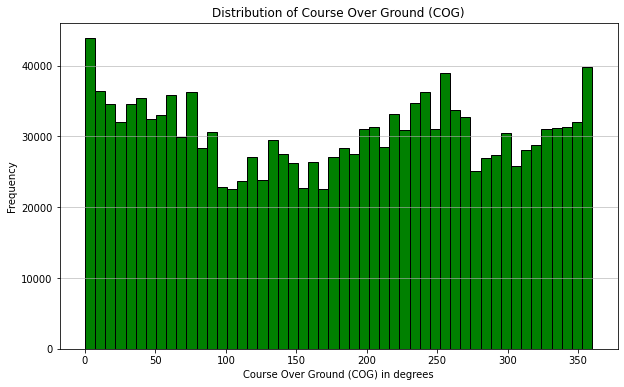

In [24]:
# Plotting the histogram for Course Over Ground (COG)
plt.figure(figsize=(10, 6))
plt.hist(data['cog'], bins=50, color='green', edgecolor='black')
plt.title('Distribution of Course Over Ground (COG)')
plt.xlabel('Course Over Ground (COG) in degrees')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()


The histogram of Course Over Ground (COG) shows a relatively uniform distribution across the 0-360 degree range, as expected for a large maritime dataset. This spread indicates that vessels are operating in various directions, with no single heading dominating the data. Slight peaks near the edges (around 0 and 360 degrees) and some minor fluctuations suggest possible preferred routes or common navigational patterns, though these are not highly pronounced. Overall, the COG distribution aligns with the expected directional variability of vessel movements.

#### Heading (heading)

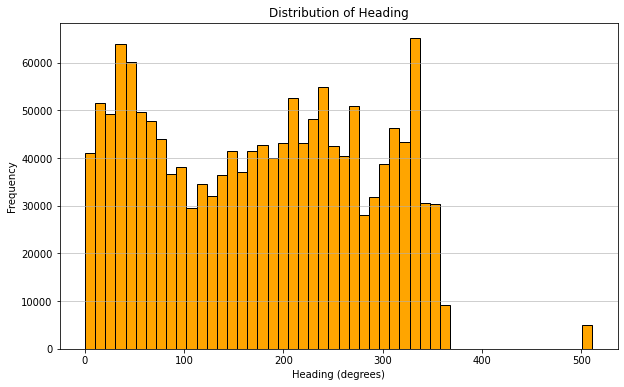

In [13]:
# Plotting the histogram for Heading
plt.figure(figsize=(10, 6))
plt.hist(data['heading'], bins=50, color='orange', edgecolor='black')
plt.title('Distribution of Heading')
plt.xlabel('Heading (degrees)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()


The histogram of Heading illustrates the orientation of vessels, measured from 0 to 360 degrees. This uniform distribution suggests that vessels are oriented in various directions based on their routes. A small set of entries shows a heading value of 511, which is a default AIS placeholder for unavailable heading data. These entries should be handled appropriately to ensure data accuracy. Within the valid range, slight peaks around certain headings may reflect common navigation routes or patterns.

#### Latitude and Longitude

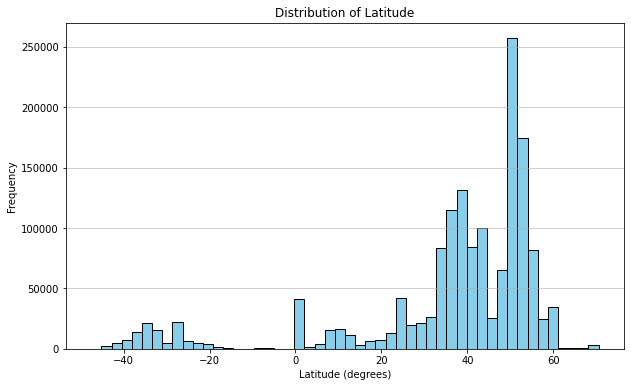

In [14]:
# Plotting the histogram for Latitude
plt.figure(figsize=(10, 6))
plt.hist(data['latitude'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Latitude')
plt.xlabel('Latitude (degrees)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()


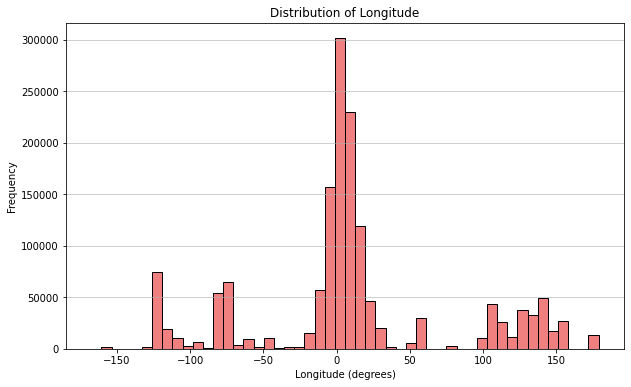

In [17]:
# Plotting the histogram for Longitude
plt.figure(figsize=(10, 6))
plt.hist(data['longitude'], bins=50, color='lightcoral', edgecolor='black')
plt.title('Distribution of Longitude')
plt.xlabel('Longitude (degrees)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()


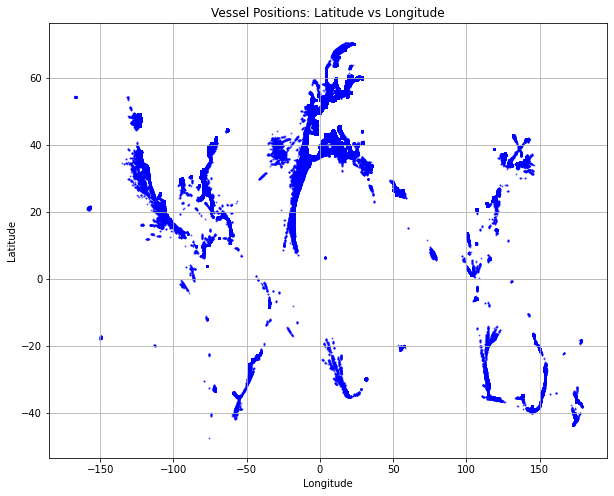

In [15]:
# Scatter plot of Latitude vs Longitude
plt.figure(figsize=(10, 8))
plt.scatter(data['longitude'], data['latitude'], s=1, alpha=0.5, color='blue')
plt.title('Vessel Positions: Latitude vs Longitude')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()


The Latitude histogram shows a clear concentration of vessel positions around 40 to 60 degrees north, suggesting that a large portion of vessel activity occurs in the northern hemisphere, likely along major shipping routes. Smaller peaks at negative latitudes indicate vessel presence in the southern hemisphere, though to a lesser extent. The Longitude histogram reveals a prominent peak near 0 degrees, highlighting vessel activity around the prime meridian, with additional clusters in other major global regions. The scatter plot of Latitude vs. Longitude brings these distributions together, forming a rough outline of the world map. This plot shows that most data entries are concentrated near coastlines and port regions, with fewer records in the open ocean. This suggests that vessel positions are primarily recorded when vessels are closer to land, likely near ports, coastal routes, or within territorial waters, with a sparse distribution in open-ocean areas.

# Data reading & preprocessing

## Preprocessing and cleaning
Hedda: litt usikker på om cleaninga her gir mening

Before traning a regression model on the data set, it is essential that we convert the data to a format that the model can actually work with. This includes encoding some of the columns, and converting data. This part of the report will highlight some of the measures taken to prepare the data for training.

In [21]:
import numpy as np
import pandas as pd

# Make a copy of the original data to avoid modifying it
data_cleaned = data.copy()

# Initial row count of the cleaned data
initial_count = len(data_cleaned)

# Convert time fields to datetime
data_cleaned['time'] = pd.to_datetime(data_cleaned['time'], errors='coerce')
data_cleaned['etaRaw'] = pd.to_datetime(data_cleaned['etaRaw'], errors='coerce')

# Track rows affected by placeholder replacement (doesn't remove rows)
sog_na_count = data_cleaned['sog'].replace([1022, 1023], np.nan).isna().sum() - data_cleaned['sog'].isna().sum()
cog_na_count = data_cleaned['cog'].replace(360, np.nan).isna().sum() - data_cleaned['cog'].isna().sum()
rot_na_count = data_cleaned['rot'].replace([-127, 127, -128], np.nan).isna().sum() - data_cleaned['rot'].isna().sum()
heading_na_count = data_cleaned['heading'].replace(511, np.nan).isna().sum() - data_cleaned['heading'].isna().sum()

# Apply placeholder replacements
data_cleaned['sog'] = data_cleaned['sog'].replace([1022, 1023], np.nan)
data_cleaned['cog'] = data_cleaned['cog'].replace(360, np.nan)
data_cleaned['rot'] = data_cleaned['rot'].replace([-127, 127, -128], np.nan)
data_cleaned['heading'] = data_cleaned['heading'].replace(511, np.nan)

# Count rows affected by out-of-range filtering
sog_filtered_count = len(data_cleaned[data_cleaned['sog'] > 35])
cog_filtered_count = len(data_cleaned[data_cleaned['cog'] > 359])
latlong_filtered_count = len(data_cleaned[~data_cleaned['latitude'].between(-90, 90)]) + len(data_cleaned[~data_cleaned['longitude'].between(-180, 180)])
navstat_filtered_count = len(data_cleaned[~data_cleaned['navstat'].between(0, 15)])

# Apply out-of-range filtering
data_cleaned = data_cleaned[data_cleaned['sog'] <= 35]
data_cleaned = data_cleaned[data_cleaned['cog'] <= 359]
data_cleaned = data_cleaned[(data_cleaned['latitude'].between(-90, 90)) & (data_cleaned['longitude'].between(-180, 180))]
data_cleaned = data_cleaned[data_cleaned['navstat'].between(0, 15)]

# Count rows affected by duplicate removal
duplicate_count = len(data_cleaned) - len(data_cleaned.drop_duplicates())

# Remove duplicates
data_cleaned = data_cleaned.drop_duplicates()

# Count missing values imputed for SOG
sog_missing_count = data_cleaned['sog'].isna().sum()

# Impute missing SOG values
data_cleaned['sog'] = data_cleaned['sog'].fillna(data_cleaned['sog'].median())

# Final row count
final_count = len(data_cleaned)

# Display summary
print("Placeholder replacements (doesn't remove rows):")
print(f"  SOG NaNs introduced: {sog_na_count}")
print(f"  COG NaNs introduced: {cog_na_count}")
print(f"  ROT NaNs introduced: {rot_na_count}")
print(f"  Heading NaNs introduced: {heading_na_count}")

print("\nOut-of-range filtering:")
print(f"  Rows with SOG > 35 removed: {sog_filtered_count}")
print(f"  Rows with COG > 359 removed: {cog_filtered_count}")
print(f"  Rows with Latitude/Longitude out of bounds removed: {latlong_filtered_count}")
print(f"  Rows with NAVSTAT out of range removed: {navstat_filtered_count}")

print("\nDuplicate rows removed:", duplicate_count)
print("\nMissing SOG values imputed with median:", sog_missing_count)

print("\nTotal rows before cleaning:", initial_count)
print("Total rows after cleaning:", final_count)
print("Total rows removed:", initial_count - final_count)


/var/folders/cj/0sj08jds0671hy9qb1nk7shw0000gn/T/ipykernel_2650/2130247674.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data_cleaned['etaRaw'] = pd.to_datetime(data_cleaned['etaRaw'], errors='coerce')


Placeholder replacements (doesn't remove rows):
  SOG NaNs introduced: 0
  COG NaNs introduced: 5858
  ROT NaNs introduced: 22381
  Heading NaNs introduced: 4895

Out-of-range filtering:
  Rows with SOG > 35 removed: 417
  Rows with COG > 359 removed: 5004
  Rows with Latitude/Longitude out of bounds removed: 0
  Rows with NAVSTAT out of range removed: 0

Duplicate rows removed: 0

Missing SOG values imputed with median: 0

Total rows before cleaning: 1522065
Total rows after cleaning: 1511173
Total rows removed: 10892


### One-hot encoding of categorical columns

Many machine learning algorithms require numerical inputs to perform calculations. Categorical data, like colors, countries, or animal types, need to be converted into a numerical format to be processed by the model. A possibility here, obviously, would be to just treat strings as their encoded versions. Another possibility would be to assign different numbers to the distinct categories. Let's say you have 5 different categories: You could assign values 1 through 5 to the different possible values, in order to encode the data numerically.

But even in cases where categorical columns are already represented as discrete integers, directly treating them as all other numerical columns does not make sense. Consider this: If 5 different colors are represented by the integers 1 through 5, treating the column directly as a numerical column implies an underlying ***order*** of the colors. More specifically, color "2" (assume blue) would be interpreted as having "twice" as much of the color attribute than that of color "1" (assume yellow), even though these are mutually exclusive and non-ordered values.

In order to address this, we could engage in 'one-hot-encoding'. The idea here is to split the categorical column into new columns, each representing a distinct value that the underlying categorical column could carry. To be clear, in the case with the colors, you would create a separate column for each possible color, and then encode the relevant color as a boolean in the matching column. To state the obvious, a single row would only have the value 1 in one of these columns, and 0 in of the others. Encoding the category as a binary value eliminates the hazard of "ordering un-ordered objects". You could interpret the value in the column of 'Color X' to represent "whether or not the current column is in fact of color X" (this would, intuitively, exclude the possibility of any other column).

#### Encoding navstat with the one-hot strategy

The 'navstat' column should represent a set of 16 distinct states (might be less in the set). It makes sense to encode this with one-hots, as we're appearantly dealing with unordered, categorical values that exclude each other. Doing this would yield 16 new binary columns each representing the presence of one of the distinct states:

In [ ]:
encoded_df = train_set.copy()
encoded_df = pd.get_dummies(encoded_df, columns=['navstat'], prefix='navstat')
encoded_df.head(5)

,time,cog,sog,rot,heading,etaRaw,latitude,longitude,vesselId,portId,navstat_0,navstat_1,navstat_2,navstat_3,navstat_5,navstat_8,navstat_15
0,2024-01-01 00:00:25,284.0,0.7,0,88,01-09 23:00,-34.74370,-57.85130,61e9f3a8b937134a3c4bfdf7,61d371c43aeaecc07011a37f,True,False,False,False,False,False,False
1,2024-01-01 00:00:36,109.6,0.0,-6,347,12-29 20:00,8.89440,-79.47939,61e9f3d4b937134a3c4bff1f,634c4de270937fc01c3a7689,False,True,False,False,False,False,False
2,2024-01-01 00:01:45,111.0,11.0,0,112,01-02 09:00,39.19065,-76.47567,61e9f436b937134a3c4c0131,61d3847bb7b7526e1adf3d19,True,False,False,False,False,False,False
3,2024-01-01 00:03:11,96.4,0.0,0,142,12-31 20:00,-34.41189,151.02067,61e9f3b4b937134a3c4bfe77,61d36f770a1807568ff9a126,False,True,False,False,False,False,False
4,2024-01-01 00:03:51,214.0,19.7,0,215,01-25 12:00,35.88379,-5.91636,61e9f41bb937134a3c4c0087,634c4de270937fc01c3a74f3,True,False,False,False,False,False,False


We now see a new column for each of the existing values in the navstat columns. However, we see from the documentation that we might not necessarily need all of the categories. Intuitively, we're most interested in whether the boat is moving or not. Exactly ***what*** state might be superficial to the model, so we could map the "moving states" to one value and the "anchored ones" to another one. Since these are mutually exclusive and collectively exhaustive, we could encode the information in a single boolean/binary column:

In [16]:
encoded_df2 = train_set.copy()

# Define the set of values that correspond to the "underway" state
underway_values = {0, 3, 4, 7, 9, 10, 11, 12, 13, 14, 15}
# Create the 'underway' column: 1 if 'navstat' is in underway_values, otherwise 0
encoded_df2['navstat'] = encoded_df2['navstat'].apply(lambda x: 1 if x in underway_values else 0)

encoded_df2

,time,cog,sog,rot,heading,navstat,etaRaw,latitude,longitude,vesselId,portId
0,2024-01-01 00:00:25,284.0,0.7,0,88,1,01-09 23:00,-34.74370,-57.85130,61e9f3a8b937134a3c4bfdf7,61d371c43aeaecc07011a37f
1,2024-01-01 00:00:36,109.6,0.0,-6,347,0,12-29 20:00,8.89440,-79.47939,61e9f3d4b937134a3c4bff1f,634c4de270937fc01c3a7689
2,2024-01-01 00:01:45,111.0,11.0,0,112,1,01-02 09:00,39.19065,-76.47567,61e9f436b937134a3c4c0131,61d3847bb7b7526e1adf3d19
3,2024-01-01 00:03:11,96.4,0.0,0,142,0,12-31 20:00,-34.41189,151.02067,61e9f3b4b937134a3c4bfe77,61d36f770a1807568ff9a126
4,2024-01-01 00:03:51,214.0,19.7,0,215,1,01-25 12:00,35.88379,-5.91636,61e9f41bb937134a3c4c0087,634c4de270937fc01c3a74f3
...,...,...,...,...,...,...,...,...,...,...,...
49995,2024-01-05 07:36:12,5.5,6.1,0,0,1,01-04 20:00,-24.03371,-46.34749,61e9f410b937134a3c4c0049,61d36fdf0a1807568ff9a1b0
49996,2024-01-05 07:36:13,94.9,0.0,0,31,0,01-02 18:00,39.64086,-0.22345,61e9f468b937134a3c4c0289,61d37fb629b60f6113c89e99
49997,2024-01-05 07:36:16,221.9,17.8,0,223,1,01-11 22:00,34.46860,138.21546,61e9f3aab937134a3c4bfe0f,61d37a221366c3998241d928
49998,2024-01-05 07:36:16,324.1,0.0,0,268,0,01-03 20:30,53.33446,7.16211,61e9f397b937134a3c4bfdaf,61d375e893c6feb83e5eb3e4


#### Encoding the other categorical columns

Similar strategies could in theory be applied to the remaining categorical columns, creating separate columns for the possible values. However, this would result in a massive increase in the amount of columns, as there are both a large amount of different vessels as well as ports. This would in its turn increase the running time of the model training, whose importance should not be underestimated. 

Note also, that you're not necessarily ***actually*** interested directly in the actual vesselId in order to make a good predicition on the position. As we will see later, you're interested in the vesselId merely to obtain ***historical data*** concerning positions/routes, or to say something about the boat's ***dimensions***. This will be addressed later in the report. As of now, we will move on without one-hot encoding the vesselId and PortId columns.

## Preprocess pipelines

Example:

For the preprocessing, we have used the following functions:

1. Aggregate the data from 15-minute intervals to hourly
2. Join the features with the target variable
3. Remove consequtive non-zero values in pv_measurement
4. Remove consequtive zero-values above 24 in length from pv_measurement
5. Remove missing values in the pv_measurement column, remove some of the columns with a lot of missing values
6. Add new features (cosine and sine transformations of hour, months and week)

In [ ]:
# Preprocess training data

# Extended Exploratory Data Analysis
Diving a bit deeper into the underlying relationships in the data might give us valuable insight for building a good model. We will take a closer look at how the features relate to one another.

We start of by looking at possible correlations between features. This might reveal patterns in the data. This is represented by a so-called correlation matrix, plotting the features against each other.

## Check if data has intuitive patterns

### Features with high positive, negative or low correlation with the target variable

In [ ]:
# Mekke feature importance plot her

### Correlation heatmaps for all features [Pairs & Groups]

In [ ]:
# mekke heatmaps, en med "features with high correlation", 
# og en "features with low correlation"

## Exploring differences between observed and estimated data

### Time series plot of estimated and observed data

Eksempel konklusjon: From the plots below, it looks like there is little difference between the observed and estimated data.

### Distribution plot of estimated and observed data

eksempel annen observasjon:

However, if we compare the distribution of the data from observed and estimated, we see that there are some differences in the values that the estimated take on (especially in t_1000 and sun_elevation). 

The difference in distribution for the sun_elevation feature can be explained by the fact that the estimated data is from october to may, meaning that the winter months are overrepresented. This skews the distribution of the sun_elevation in comparison to the observed data, which spans over multiple years. Since sun_elevation is lower during the winter months, the distribution for estimated sun_elevation conists of fewer values of high elevation (>20). The same logic can be applied to the t_1000hPa:K, which is temperature in Kelvin at 1000hPa pressure. 

We believe these differences are negligible.

# Model testing [Multiple predictors]

eksempel:

We have tested three types of models: Pycaret, Autogluon and Catboost (and variations/ensembles/stackings of these).

In our comparative analysis, each model showed both strengths and weaknesses, with variations in performance metrics across different datasets. Pycaret showcased versatility in automating the ML workflow, Autogluon excelled in time efficiency and ease of use, while Catboost demonstrated superior handling of categorical data and complex relationships. The incorporation of ensemble and stacking techniques further enhanced predictive capabilities, underscoring the potential of hybrid approaches in tackling diverse data challenges.

## Pycaret

eksempel:

The group only tried one Pycaret pipeline before changing to Autogluon + Catboost.

We tried various hyperparameters, including training time, number of folds, with/without eval set, eval size, none of which ended up outperforming Autogluon or Catboost.

## Autogluon

eksempel:

For Autogluon, we tried training one model for each location, as well as one model that predicted on all three locations. The first method yielded the best results, both methods are listed below. 

In addition, we tried a lot of different hyperparameters for Autogluon, experimenting and seeing which combinations gave the best metrics, both locally and on Kaggle. 

### Autogluon V1

eksempel: This model trains one model for each location.

### Autogluon V2

eksempel: 3 Autogluon with tuning data, no new features, remove 0 pv during daytime, random sample eval dataset from full dataset

### Autogluon V3

eksmepl: 3 Autogluon without tuning data, no new features, remove 0 pv during daytime

### Autogluon V4

eksempel: Experiment with longer training times Autogluon stacking and ensembling.

### Autogluon V5

eksempel: Our best autogluon model so far.

## Catboost

eksempel: Our first catboost simple was very simple. We later started experimenting with training multiple catboost models with randomized parameters and randomized train/val split, which proved to give decent results.

### Catboost V1

eksempel: Catboost with one model for all locations

### Catboost V2

eksempel: Catboost with one model for each location

### Catboost V3

eksempel: Catboost ensemble model, training 20 catboost models with random train val split (to increase variance before averaging). 

### Catboost V4

eksempel: Training 20 catboost models with random train val split and random parameters (within given ranges)

### Catboost V5

eksempel: Our best catboost model. Ensemble model.

## Average models

Eksempel: In addition to Catboost and Autogluon, we found that averaging them out with a weighted average produced good scores. 

Since our catboost models performed a bit better than the autogluon, we decided to weight the catboost models a bit higher.

The average models are the ones that performed the best on kaggle.

The submissions were produced by separately running the Autogluon and catboost models, then averaging the final test predictions.

### Model 1: Autogluon

#### Autogluon

#### Train one model for each location

#### Plotting

#### Submission

### Model 2: Catboost

#### Import libraries

### Ensemble: Weighted average of Model 1 and Model 2